In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.ensemble import BaggingRegressor,BaggingClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, \
accuracy_score, precision_score, confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, cross_val_predict
import random as rm
from sklearn import metrics
from sklearn import impute
import sklearn as sk
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


In [57]:
df = pd.read_csv("water_potability.csv")
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [68]:
X = df.drop(columns= 'Potability')
y = df['Potability']

In [59]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [60]:
MSE_whole_data = []
#Iterate over the potential optimal values of the hyperparameter 'k' of the KNN algorithm
for k in range(1, 51):
    #Impute the missing values of X_scaled (5380 rows, 765 columns) with the 'k' under consideration
    #Let us call the imputed dataset as 'X_imputed_k'. This dataset has no missing values.
    imputer = KNNImputer(n_neighbors=k)
    X_imputed_k = imputer.fit_transform(X_scaled)
    X_imputed_k = pd.DataFrame(X_imputed_k, columns=X_scaled.columns)
    MSE_multiplied = []
    MSE = []
    #Iterate over each predictor in the data
    for predictor in X_scaled.columns:
        #If there are no missing values in 'predictor', skip the lines below, and continue with the next predictor
        if X_scaled[predictor].isna().sum() == 0:
            continue
        #Remove the observations from 'X_imputed_k', where the 'predictor' has actual missing values.
        #We don't know the true values of those observations for the 'predictor' column, and hence cannot 
        #compute the cross-validation error on them. Let the dataframe with the removed observations be
        #X_imputed_non_missing_k 
        missing_mask = X_scaled[predictor].isna()
        X_imputed_non_missing_k = X_imputed_k.loc[~missing_mask, :]
        #Similarly, remove the observations that have missing values in 'predictor' and call the 
        #resulting Series as 'predictor_nonmissing'
        predictor_nonmissing = X_scaled.loc[~missing_mask, predictor]
        #Consider 'predictor_nonmissing' as the response, and 'X_imputed_non_missing_k' as predictors
        knn = KNeighborsRegressor(n_neighbors=k)
        #Use cross_val_score to compute the 5-fold cross-validated MSE when 'predictor_nonmissing' is 
        #predicted using 'X_imputed_non_missing_k' as the set of predictors, with the KNN model having
        #K = k
        cv_scores= -cross_val_score(knn, X_imputed_non_missing_k, predictor_nonmissing, cv=5, scoring='neg_mean_squared_error')
        #Compute the weighted average of MSEs, and then MSE_whole_data_k as mentioned in steps 6-7 of the announcement
        MSE.append(np.mean(cv_scores))
        MSE_multiplied.append(np.mean(cv_scores) * missing_mask.sum())
    total_se_k = sum(MSE_multiplied)
    MSE_whole_data_k = total_se_k / X_scaled.isnull().sum().sum()
    MSE_whole_data.append(MSE_whole_data_k)

In [61]:
# Find optimal K
optimal_k = np.argmin(MSE_whole_data) + 1
MSE_optimal_k = MSE_whole_data[optimal_k - 1]
print("Optimal K:", optimal_k)
print('MSE for the optimal K:', MSE_optimal_k)

Optimal K: 5
MSE for the optimal K: 0.16072247870117018


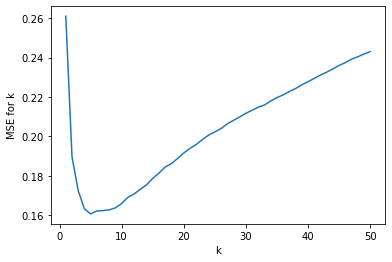

In [62]:
#plot MSEwhole_data_k vs k, and report the (2) optimal K, (3) MSEwhole_data_K for the optimal K, and (4) the option (a) or (b) chosen in step 4.
#Note that this template is for following option (a) in step 4 in the announcement.
# Plot MSEwhole_data_k vs k
plt.plot(range(1, 51), MSE_whole_data)
plt.xlabel('k')
plt.ylabel('MSE for k')
plt.show()

In [64]:
# Select the columns with missing values
columns_with_missing = ['ph', 'Sulfate', "Trihalomethanes"]

# Create a copy of the DataFrame
impute_X = X_scaled.copy()

# Perform KNN imputation with the optimal K value
imputer = KNNImputer(n_neighbors=5, weights="uniform")
imputed_data = imputer.fit_transform(impute_X[columns_with_missing])

# Update the original DataFrame with the imputed values
X_scaled[columns_with_missing] = imputed_data

In [65]:
X_scaled.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,-0.209627,0.259195,-0.139471,0.112415,0.838973,1.708954,-1.180651,1.273445,-1.286298
1,-2.110818,-2.036414,-0.385987,-0.307694,-0.512637,2.062575,0.270597,-0.622493,0.684218
2,0.638838,0.847665,-0.240047,1.360594,-0.333799,-0.094032,0.781117,0.001472,-1.167365
3,0.775374,0.547651,0.000493,0.592008,0.558106,-0.778830,1.255134,2.098969,0.848412
4,1.261849,-0.464429,-0.460249,-0.363698,-0.570898,-0.343939,-0.824357,-2.126974,0.138786


In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, random_state = 45)

# Do we need to scale values? if so, should they be scaled for train and test? should our test data have imputed values as well, or just train data?

In [70]:
X_train.shape

(2293, 9)

**Going to measure RMSE because larger errors are more important to consider. This is because a small error in a metric may not mean the difference between potable and not, but a large error very well could.**

**Baseline model**

In [71]:
model=DecisionTreeClassifier(random_state=1)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [72]:
print("Maximum tree depth =", model.get_depth())
print("Maximum leaves =", model.get_n_leaves())

Maximum tree depth = 29
Maximum leaves = 455


In [73]:
model = DecisionTreeClassifier(random_state=1, max_depth=29, max_leaf_nodes=455, max_features=9).fit(X_train, y_train)

# how to print precision for baseline model

**Tuning decision tree**

In [10]:
# Grid search to optimize parameter values
parameters = {'max_depth': range(2, 29, 2), 'max_leaf_nodes': range(2, 455, 10), 'max_features':range(2, 9)}
cv=KFold(n_splits=5, shuffle=True, random_state=1)
model=GridSearchCV(DecisionTreeClassifier(random_state=1), parameters, n_jobs=-1, verbose=1, cv=cv,
                  scoring=['precision', 'recall'], refit='precision')
model.fit(X_train, y_train)
print("Best accuracy through grid search : %.3f"%model.best_score_)
print("Best params for precision")
print(model.best_params_)


Fitting 5 folds for each of 1421 candidates, totalling 7105 fits
Best accuracy through grid search : 0.673
Best params for precision
{'max_depth': 5, 'max_features': 5, 'max_leaf_nodes': 32}


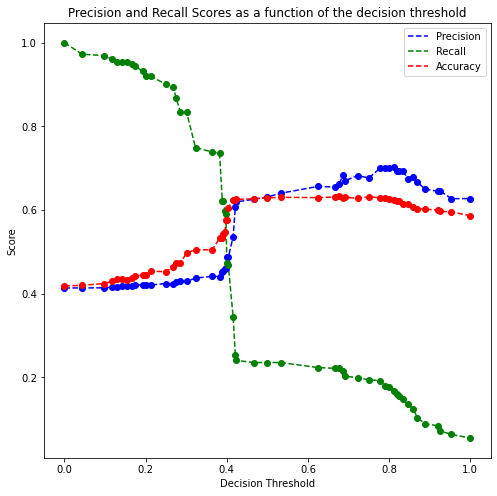

In [11]:
model = DecisionTreeClassifier(random_state=1, max_depth=5, max_leaf_nodes=32, max_features=5).fit(X_train, y_train)

cross_val_ypred=cross_val_predict(DecisionTreeClassifier(random_state=1, max_depth=5,
                                                        max_leaf_nodes=32, max_features=5), X_train,
                                 y_train, cv=5, method='predict_proba')

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:, 1])
acc=np.ndarray(shape=(len(thresholds),))
i=0
for th in thresholds:
    y_pred = cross_val_ypred[:, 1]>th
    y_pred=y_pred.astype(int)
    acc[i]=accuracy_score(y_pred, y_train)
    i = i+1
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.plot(thresholds, acc, "r--", label="Accuracy")
    plt.plot(thresholds, precisions[:-1], "o", color='blue')
    plt.plot(thresholds, recalls[:-1], "o", color='green')
    plt.plot(thresholds, acc, "o", color = 'red')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc="best")
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

In [12]:
all_thresholds = np.concatenate([thresholds.reshape(-1, 1), acc.reshape(-1, 1), r[:-1].reshape(-1,1)], axis=1)
precision_more_than_60=all_thresholds[all_thresholds[:,0]>0.6, :]

In [13]:
all_thresholds

array([[0.        , 0.41862118, 1.        ],
       [0.04347826, 0.42004264, 0.97250859],
       [0.09803922, 0.42430704, 0.96907216],
       [0.11627907, 0.42928216, 0.9604811 ],
       [0.13043478, 0.43425729, 0.95360825],
       [0.14285714, 0.43496802, 0.95360825],
       [0.15384615, 0.43283582, 0.95360825],
       [0.16666667, 0.43781095, 0.94845361],
       [0.17431193, 0.44278607, 0.94501718],
       [0.19230769, 0.4434968 , 0.93127148],
       [0.2       , 0.4434968 , 0.9209622 ],
       [0.21428571, 0.45344705, 0.91924399],
       [0.25      , 0.45273632, 0.90034364],
       [0.26794258, 0.46481876, 0.895189  ],
       [0.275     , 0.47263682, 0.86769759],
       [0.28571429, 0.47334755, 0.83333333],
       [0.30093458, 0.49751244, 0.83333333],
       [0.32291667, 0.50533049, 0.74914089],
       [0.36363636, 0.50461976, 0.73883162],
       [0.38216561, 0.53233831, 0.73539519],
       [0.38888889, 0.53375977, 0.62199313],
       [0.39153439, 0.54228856, 0.62199313],
       [0.

In [14]:
precision_more_than_60[precision_more_than_60.shape[0]-1]

array([1.        , 0.58635394, 0.05498282])

**definitely tune max_features. Don't need to tune n_estimators, just make it high, like around 250. Tuning max_depth and max_lead_nodes is not as important. Don't tune max_features over the number of predictors.**